In [ ]:
!pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a

  Cloning https://github.com/haotian-liu/LLaVA.git (to revision 786aa6a19ea10edc6f574ad2e16276974e9aaa3a) to /tmp/pip-req-build-jp6s6w1i
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-jp6s6w1i
  Running command git rev-parse -q --verify 'sha^786aa6a19ea10edc6f574ad2e16276974e9aaa3a'
  Running command git fetch -q https://github.com/haotian-liu/LLaVA.git 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Running command git checkout -q 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO

In [ ]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-7b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        """Load the model, processor and tokenizer."""
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor
        disable_torch_init()

    def setup_image(self, img_path: str) -> None:
        """Load and process the image."""
        if img_path.startswith('http') or img_path.startswith('https'):
            response = requests.get(img_path)
            self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            self.conv_img = Image.open(img_path).convert('RGB')
        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img_path: str,
                       prompt: str,
                       do_sample=True,
                       temperature=0.2,
                       max_new_tokens=1024,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img_path)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles
        first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                       DEFAULT_IM_END_TOKEN + '\n' + prompt)
        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.2,
                      max_new_tokens=1024,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

In [ ]:
!pip install torch

In [ ]:
import torch

chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
ans = chatbot.start_new_chat(img_path="/content/download.jpeg",
                             prompt="Is this an image of a dog")

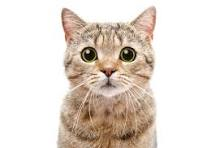

In [ ]:
display(chatbot.conv_img)

In [ ]:
print(ans)

No, this is an image of a cat.


In [ ]:
ans = chatbot.continue_chat("write a description of the animal in the image")

In [ ]:
print(ans)

The image features a close-up of a cat with yellow eyes, looking directly at the camera. The cat has a fluffy coat and appears to be staring intently at the viewer.


Get the full conversation

In [ ]:
print(chatbot.get_conv_text())

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <im_start><image><im_end>
Is this an image of a dog ASSISTANT: No, this is an image of a cat.</s></s>USER: write a description of the animal in the image ASSISTANT: The image features a close-up of a cat with yellow eyes, looking directly at the camera. The cat has a fluffy coat and appears to be staring intently at the viewer.</s></s>
